# Water Model Calibration

In [152]:
import wntr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp
import chaospy as cp
from ipypb import track
from matplotlib import cm

# Helper Methods

In [2]:
def extractDataFrame(wn,objType="Pipe"):
    objsDict = {}
    try:
        objIter = wn.pipes()
        if objType == "Junction":
            objIter = wn.junctions()
        elif objType == "Tank":
            objIter = wn.tanks()
        elif objType == "Reservoir":
            objIter = wn.reservoirs()
        for obj in objIter:
            obj = obj[1]
            objDict = obj.todict()
            for k,v in objDict.items():
                if k in objsDict.keys():
                    objsDict[k].append(v)
                else:
                    objsDict[k] = [v]
        objsDF = pd.DataFrame(objsDict)
        return objsDF
    except:
        return objsDict

In [3]:
class ResultHelper():
    def __init__(self,results,convertResultsToHours=True):
        self.results = results
        
        # programatically set nodes
        for nodeKey in results.node.keys():
            self.__dict__[nodeKey] = results.node[nodeKey].T
        
        # progrmatically set links
        for linkKey in results.link.keys():
            self.__dict__[linkKey] = results.link[linkKey].T
        
        if convertResultsToHours:
            self.convertResultsToHours()
            
    def help(self):
        return list(self.__dict__.keys())
        
    def convertResultsToHours(self):
        for prop,value in self.__dict__.items():
            if type(value) == pd.DataFrame:
                value.columns = [float(seconds)/3600.0 for seconds in value.columns]
                
    def returnResult(self,resultType,resultLocationID,time):
        if resultType in self.__dict__.keys():
            resultDF = self.__dict__[resultType]
            if resultLocationID in resultDF.index:
                if time in resultDF.columns:
                    return self.__dict__[resultType].loc[resultLocationID][time]
                else:
                    print(f"{time} is not a valid time")
            else:
                print(f"{resultLocationID} is not a valid element in the network")
        else:
            print(f"{resultType} is not a valid property for ResultAnalyzer")
            return None

In [4]:
class Sensor():
    def __init__(self,sensorType,name,sensorSTD,dictOfPropertyValues):
        self.sensorType = sensorType
        self.name = name
        self.sensorSTD = sensorSTD
        self.dictOfPropertyValues = dictOfPropertyValues
        self.dictOfPropertyModelEstimates = {k:[] for k in dictOfPropertyValues.keys()}
        
    def calculateProbability(self,resultHelper):
        p = 1.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(sensorObservationValue,self.sensorSTD)
            p *= distribution.pdf(modelResult)
        return p
    
    def calculateProbability_Summed(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += distribution.pdf(sensorObservationValue)
        return p        
    
    def calculateProbability_Summed_Log(self,resultHelper):
        p = 0.0
        for sensorObservationTime,sensorObservationValue in self.dictOfPropertyValues.items():
            modelResult = resultHelper.returnResult(self.sensorType,self.name,sensorObservationTime)
            self.dictOfPropertyModelEstimates[sensorObservationTime].append(modelResult)
            distribution = stats.norm(modelResult,self.sensorSTD)
            p += np.log(distribution.pdf(sensorObservationValue))
        return p       

In [5]:
class WaterNetworkHelper():
    def __init__(self,wn,name="Water Network"):
        self.wn = wn
        self.updatePipes()
        self.name = name
        
    def updatePipes(self):
        self.pipes = extractDataFrame(self.wn).set_index("name")
        self.nodes = extractDataFrame(self.wn,"Junction").set_index("name")
        self.tanks = extractDataFrame(self.wn,"Tank").set_index("name")
        self.reservoirs = extractDataFrame(self.wn,"Reservoir").set_index("name")
        
    def setPipeDiameter(self,pipeID,newDiameter):
        pipe = self.wn.get_link(pipeID)
        pipe.diameter = newDiameter
        self.updatePipes()
    
    def setPipeRoughness(self,pipeID,newRoughness):
        pipe = self.wn.get_link(pipeID)
        pipe.roughness = newRoughness
        self.updatePipes()
    
    def setPipeStatus(self,pipeID,newStatus):
        pipe = self.wn.get_link(pipeID)
        pipe.status = newStatus
        self.updatePipes()
            
    def runSimulation(self):
        sim = wntr.sim.EpanetSimulator(self.wn)
        results = ResultHelper(sim.run_sim())
        return results        
    
    def plotNetwork(self,figsize=(10,10),link_attribute=None,node_attribute=None):
        fig,ax = plt.subplots(figsize=figsize)
        wntr.graphics.plot_network(self.wn, title=self.name,ax=ax,node_attribute=node_attribute,link_attribute=link_attribute)

In [260]:
class Calibrator():
    def __init__(self,elementName,elementProperty,distribution):
        self.elementName = elementName
        self.elementProperty = elementProperty
        self.prior = distribution # type of distribution
        self.values = []
        self.proposedValues = []
        
    def generateProposal(self):
        return self.prior.rvs()
    
    def generateTransition(self,currentValue=None,σ=None):
        if not currentValue:
            currentValue = self.values[-1]
        if not σ:
            σ = self.prior.std()
        # simple gaussian case
        dist = stats.norm(currentValue,σ)
        return dist.rvs()
    
    def calculateProbability(self,value):
        return self.prior.pdf(value)
    
    def calculateProbability_Transition(self,value):
        dist = stats.norm(self.values[-1],self.prior.std())
        return dist.pdf(value)
        
    def setValue(self,waterNetworkHelper,newValue):
        if self.elementProperty == "diameter":
            waterNetworkHelper.setPipeDiameter(self.elementName,newValue)
        elif self.elementProperty == "roughness":
            waterNetworkHelper.setPipeRoughness(self.elementName,newValue)
        elif self.elementProperty == "status":
            waterNetworkHelper.setPipeStatus(self.elementName,newValue)
            
    def plot(self,trueValue,burnin=0.0):
        columnName = f"{self.elementName} {self.elementProperty}"
        valuesSubset = self.values[int(burnin*len(self.values)):len(self.values)+1]
        calibratorDFToPlot = pd.DataFrame({columnName:valuesSubset})
        fig,ax = plt.subplots(figsize=(10,10))
        calibratorDFToPlot.plot(kind="hist",ax=ax,legend=False,density=True)
        ax.axvline(trueValue,color="red",ls="--",label="True Value")
        ax.set_title(f'{columnName}\nCalibrated Mean: {calibratorDFToPlot[columnName].mean():.1f}, Calibrated Median: {calibratorDFToPlot[columnName].median():.1f}\nTrue Value: {trueValue:.1f}\nPrior Mean: {self.prior.mean():.1f}')
        ax.set_xlabel(calibrator.elementProperty)
        
        # add the prior distribution
        priorEstimates = []
        
        lspace = np.linspace(0,220,10000)
        ns = self.prior.pdf(lspace)
        sns.lineplot(lspace,ns,ax=ax,color="orange",alpha=0.2,label="Prior")
        ax.fill_between(lspace,ns, color="orange", alpha=0.1)
        
#         for i in range(0,10000):
#             priorEstimates.append(self.generateProposal())
#         priorEstimatesDF = pd.DataFrame({"Prior":priorEstimates})
#         priorEstimatesDF.plot(kind="hist",ax=ax,color="orange",alpha=0.1,label="Prior",density=True)
        return ax

# Set up Base (True Model)

(<matplotlib.collections.PathCollection at 0x1f4a1c56e08>,
 <matplotlib.collections.LineCollection at 0x1f4a1d9cc08>)

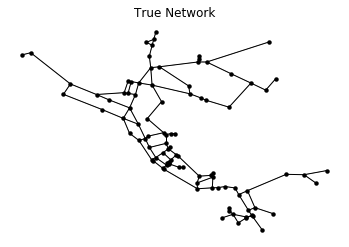

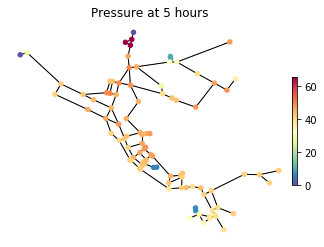

In [8]:
# Create a water network model
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn_true, title="True Network")

# Simulate hydraulics
sim_true = wntr.sim.EpanetSimulator(wn_true)
results_true = sim_true.run_sim()

# Plot results on the network
pressure_at_5hr = results_true.node['pressure'].loc[5*3600, :]
wntr.graphics.plot_network(wn_true, node_attribute=pressure_at_5hr, node_size=30, 
                        title='Pressure at 5 hours')

# Set up Altered Model

In [69]:
testNetwork = WaterNetworkHelper(wn_true)

In [71]:
testNetwork.plotNetwork(link_attribute="roughness",node_attribute="demand",link_label=True)

TypeError: plotNetwork() got an unexpected keyword argument 'link_label'

In [ ]:
testSensor = Sensor("demand","15",0.01,{0.0:.04,0.25:0.038})

In [ ]:
testNetwork.setPipeDiameter("20",4)

In [ ]:
testNetwork.pipes.loc["151"]

In [ ]:
testResult = testNetwork.runSimulation()

In [ ]:
testResult.flowrate

In [ ]:
testResult.pressure

In [ ]:
testSensor.calculateProbability(testResult)

In [ ]:
testCalibrator = Calibrator("20","diameter",stats.norm(6,2))

# Setting Up

In [9]:
def π_Transition(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateTransition()
        estimatesDict[calibrator] = rv
    return estimatesDict             

In [10]:
"""
This function generates the random numbers for the parameters being tested
"""
def π(listOfCalibrators):
    estimatesDict = {}
    for calibrator in listOfCalibrators:
        rv = calibrator.generateProposal()
        estimatesDict[calibrator] = rv
    return estimatesDict     

In [11]:
π([testCalibrator])

NameError: name 'testCalibrator' is not defined

In [12]:
"""
This function calculates the probability that the parameters are 
pulled from their distribution
"""
def π_Prior(estimatesDict):
    p = 1.0
    for calibrator,parameterValue in estimatesDict.items():
#         pi = calibrator.calculateProbability(parameterValue)
        pi = calibrator.calculateProbability_Transition(parameterValue)
        p *= pi
    return p

In [13]:
π_Prior({testCalibrator:6.3})

NameError: name 'testCalibrator' is not defined

In [14]:
"""
This function loops through a set of observations and calculates the
log-liklihood of each, summed
"""
def π_Log_Liklihood(listOfSensors,modelResult):
    logLiklihood = 0.0
    for sensor in listOfSensors:
        logLiklihood += sensor.calculateProbability_Summed_Log(modelResult)
#         logLiklihood += sensor.calculateProbability_Summed(modelResult)
#     logLiklihood = np.log(logLiklihood)
    return logLiklihood

In [15]:
π_Log_Liklihood(listOfSensors,currentModelResult)

NameError: name 'listOfSensors' is not defined

In [16]:
np.log(.3) + np.log(.5)

-1.8971199848858813

In [17]:
np.log(.8)

-0.2231435513142097

In [18]:
def MCMC():
    return None

In [19]:
def GA():
    return None

In [20]:
def setParameterValues(proposedParameters):
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.values.append(proposedParameterValue)

# MCMC Step By Step

In [378]:
# Set up the known network
inp_file = 'networks/Net3.inp'
wn_true = wntr.network.WaterNetworkModel(inp_file)
waterNetwork = WaterNetworkHelper(wn_true)
testResult = waterNetwork.runSimulation()

In [379]:
testResult.pressure

,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,165.75,166.00,166.25,166.50,166.75,167.00,167.25,167.50,167.75,168.00
name,,,,,,,,,,,,,,,,,,,,,
10,-0.450070,-0.412124,-0.373856,-0.335356,28.253771,28.271534,28.289356,28.307182,28.764025,28.788130,...,0.907047,0.372047,0.362341,0.353657,0.345960,-0.651304,-0.679442,-0.706920,-0.733592,0.201616
15,28.593657,28.646694,28.699520,28.752108,28.885527,28.962927,29.040131,29.117128,29.999800,30.099121,...,38.714005,34.835178,34.861679,34.887859,34.913715,34.475533,34.484104,34.492184,34.499786,29.216721
20,8.839204,8.904196,8.968541,9.032248,9.095346,9.183346,9.270848,9.357861,9.444409,9.549258,...,9.110834,9.177398,9.227413,9.275954,9.323068,9.368799,9.395933,9.421527,9.445627,9.468291
35,40.612469,40.648396,40.684673,40.721203,41.515289,41.584351,41.653622,41.723015,42.429352,42.531441,...,41.672138,41.488880,41.471237,41.454845,41.439667,40.998650,40.961136,40.924675,40.889191,41.281269
40,3.992880,4.042458,4.090409,4.136927,4.182194,4.290183,4.395753,4.499026,4.600117,4.735769,...,5.229321,5.251928,5.211545,5.174491,5.140712,5.110128,5.032933,4.959072,4.888481,4.821076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
River,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Lake,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.992880,4.042458,4.090409,4.136927,4.182194,4.290178,4.395748,4.499026,4.600112,4.735765,...,5.229321,5.251928,5.211545,5.174491,5.140712,5.110128,5.032933,4.959076,4.888481,4.821076


# Set the calibrators
calibrator1 = Calibrator("20","roughness",stats.norm(190,20))
calibrator2 = Calibrator("40","roughness",stats.norm(200,10))
calibrator3 = Calibrator("333","roughness",stats.norm(130,20))

listOfCalibrators = [calibrator1,calibrator2,calibrator3]

## Try Setting Up Calibrators and Sensors on Same Lines!

In [380]:
toCalibrate = ["204","225","229","173"]
listOfCalibrators = []
listOfSensors = []
calibratorPipes = []
trueValues = {}
pAddCalibrator = 0.05
for i,row in waterNetwork.pipes.iterrows():
    if i in toCalibrate:
        actualRoughness = row["roughness"]
        dist = stats.norm(actualRoughness,15)
        randomRoughness = dist.rvs()
        calibrator = Calibrator(i,"roughness",stats.norm(randomRoughness,15))
        trueValues[calibrator] = actualRoughness
        listOfCalibrators.append(calibrator)
        calibratorPipes.append(i)

toCalibrate = ["204","225","229"]
listOfCalibrators = []
listOfSensors = []
calibratorPipes = []
trueValues = {}
pAddCalibrator = 0.05
for i,row in waterNetwork.pipes.iterrows():
    rand = np.random.random()
    if rand < pAddCalibrator:
        actualRoughness = row["roughness"]
        dist = stats.norm(actualRoughness,15)
        randomRoughness = dist.rvs()
        calibrator = Calibrator(i,"roughness",stats.norm(randomRoughness,15))
        trueValues[calibrator] = actualRoughness
        listOfCalibrators.append(calibrator)
        calibratorPipes.append(i)

for sensorName,row in testResult.flowrate.iterrows():
    sensorProperty = "flowrate"
    sensorSTD = 0.001
    sensorDict = {}
    sensorDict[5.00] = row[5.00]
    sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
    if sensorName in calibratorPipes:
        listOfSensors.append(sensor)

trueValues = {calibrator1:199,calibrator2:199,calibrator3:140}

In [381]:
listOfSensors = []
pAddSensor = 0.2
for i,row in testResult.flowrate.iterrows():
    sensorProperty = "flowrate"
    sensorName = i
    sensorSTD = 0.001
    sensorDict = {}
#     for time in testResult.pressure.columns:
#         sensorDict[time] = row[time]
    sensorDict[2.25] = row[2.25]
    sensorDict[5.00] = row[5.00]
    sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
    rand = np.random.random()
    if rand < pAddSensor:
        listOfSensors.append(sensor)

In [382]:
# try a pressure sensor
listOfSensors = []
pAddSensor = 0.05
for i,row in testResult.pressure.iterrows():
    sensorProperty = "pressure"
    sensorName = i
    sensorSTD = 0.5
    sensorDict = {}
#     for time in testResult.pressure.columns:
#         sensorDict[time] = row[time]
    sensorDict[2.25] = row[2.25]
    sensorDict[5.00] = row[5.00]
    sensor = Sensor(sensorProperty,sensorName,sensorSTD,sensorDict)
    rand = np.random.random()
    if rand < pAddSensor:
        listOfSensors.append(sensor)

sensor1 = Sensor("pressure","15",2,{0.0:28.593653,0.25:28.646692})
sensor2 = Sensor("pressure","40",1,{0.0:3.992880,0.25:4.042458})

listOfSensors = [sensor1,sensor2]

In [383]:
iterations = []
acceptanceRatios = []
isAccepted = []

In [384]:
currentParameters = π(listOfCalibrators)
for calibrator,proposedParameterValue in currentParameters.items():
    calibrator.values.append(proposedParameterValue)
    calibrator.setValue(waterNetwork,proposedParameterValue)
currentModelResult = waterNetwork.runSimulation()

In [385]:
n = 100

In [386]:
for i in track(range(0,n)):
    iterations.append(i)
    
    # generate a set of proposed values as a starting point
    proposedParameters = π_Transition(listOfCalibrators)
    for calibrator,proposedParameterValue in proposedParameters.items():
        calibrator.proposedValues.append(proposedParameterValue)
        # udpate the model
        calibrator.setValue(waterNetwork,proposedParameterValue)
    
    # run the model
    try:
        modelResult = waterNetwork.runSimulation()

        # calculate the acceptance probabilities
        α_1 = 0 #np.log(π_Prior(proposedParameters))
        α_2 = π_Log_Liklihood(listOfSensors,modelResult)
        α_3 = 0 #np.log(π_Prior({calibrator:calibrator.values[-1] for calibrator in listOfCalibrators}))
        α_4 = π_Log_Liklihood(listOfSensors,currentModelResult)
        α = np.exp(α_1 + α_2 - α_3 - α_4)
        α = min(1.0,α)
        acceptanceRatios.append(α)
        accepted = False

        # decide if we accept
        if α == 1: # accept
            setParameterValues(proposedParameters)
            currentParameters = proposedParameters
            currentModelResult = modelResult
            accepted = True
        else: # draw a random number and take the probability based on α
            rand = np.random.random()
            if rand < α: # accept
                setParameterValues(proposedParameters)
                currentParameters = proposedParameters
                currentModelResult = modelResult
                accepted = True
            else:
                setParameterValues(currentParameters)

        # update our iteration
        # update parameter histories
        isAccepted.append(accepted)
    except:
        pass

# generate the return data frame


 [████████████████████████████████████████████████████████████] 100/100 [00:25<00:00, 0.25s/it]

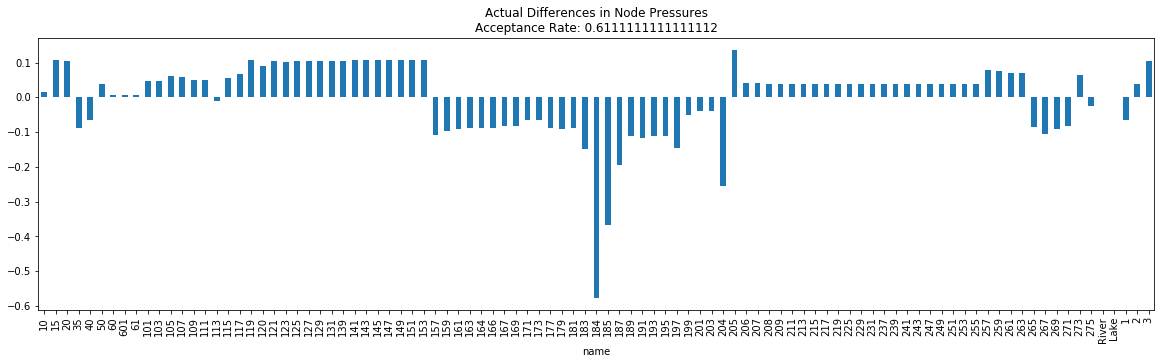

In [387]:
fig,ax = plt.subplots(figsize=(20,5))
(testResult.pressure[5.00] - currentModelResult.pressure[5.00]).plot(ax=ax,kind="bar")
ax.set_title(f"Actual Differences in Node Pressures\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)}");

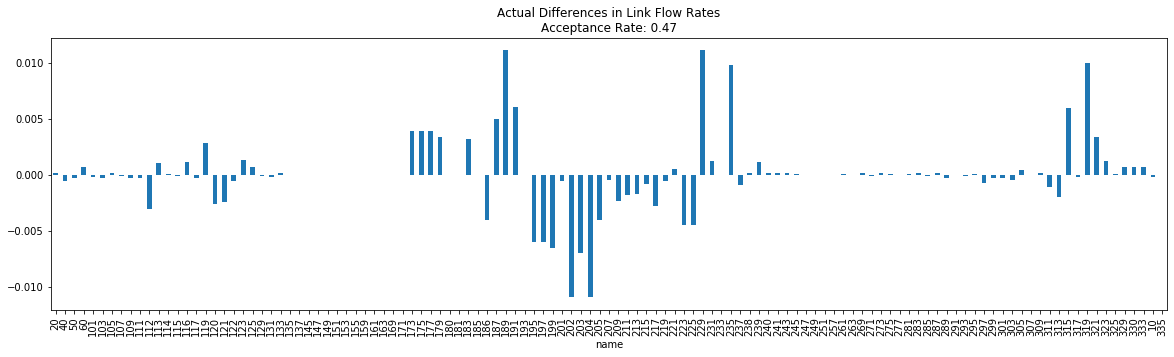

In [376]:
fig,ax = plt.subplots(figsize=(20,5))
(testResult.flowrate[5.00] - currentModelResult.flowrate[5.00]).plot(ax=ax,kind="bar")
ax.set_title(f"Actual Differences in Link Flow Rates\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)}");

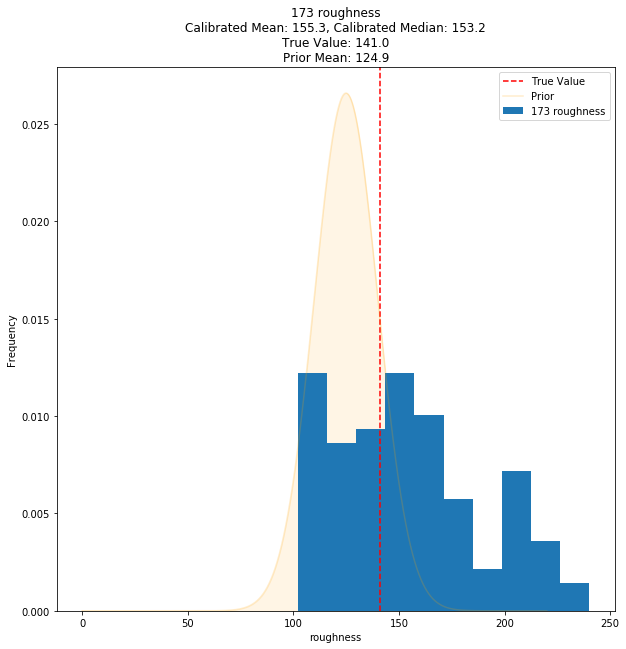

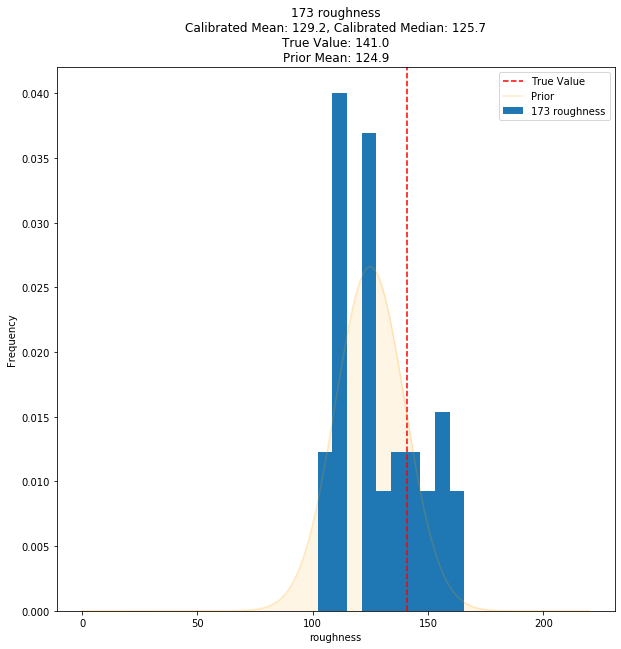

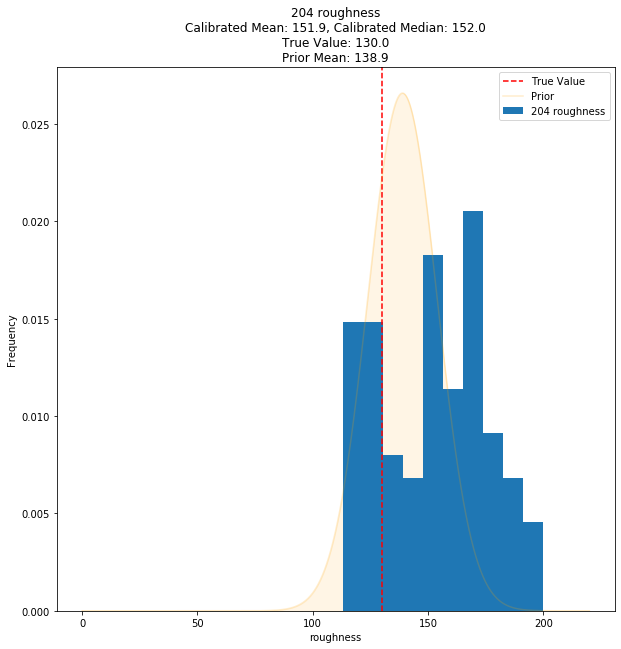

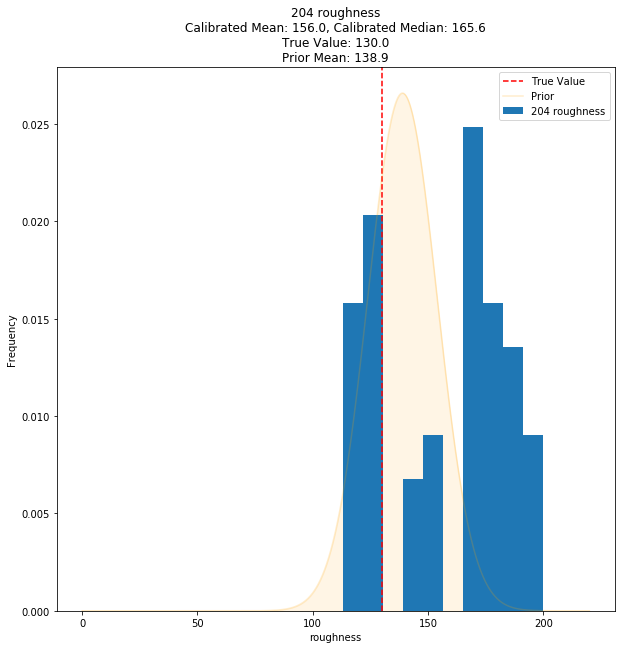

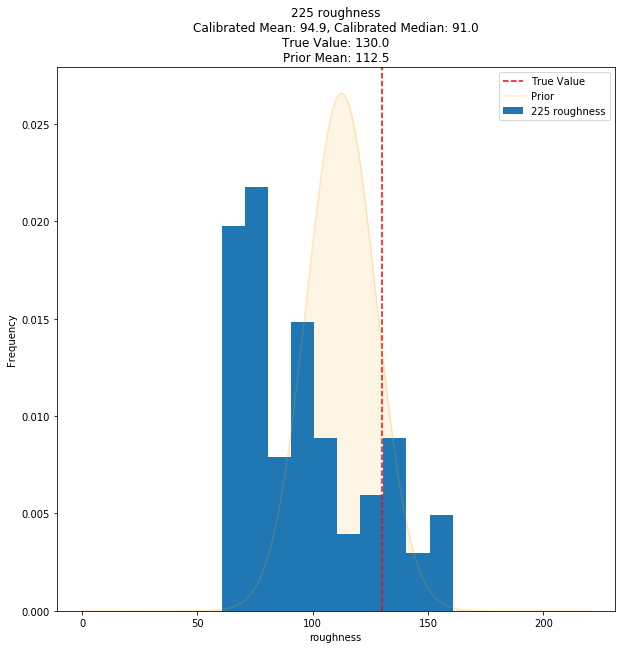

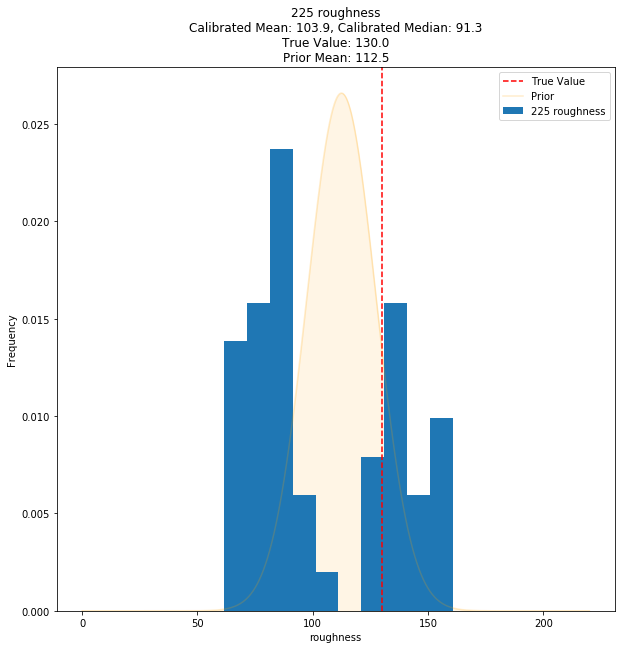

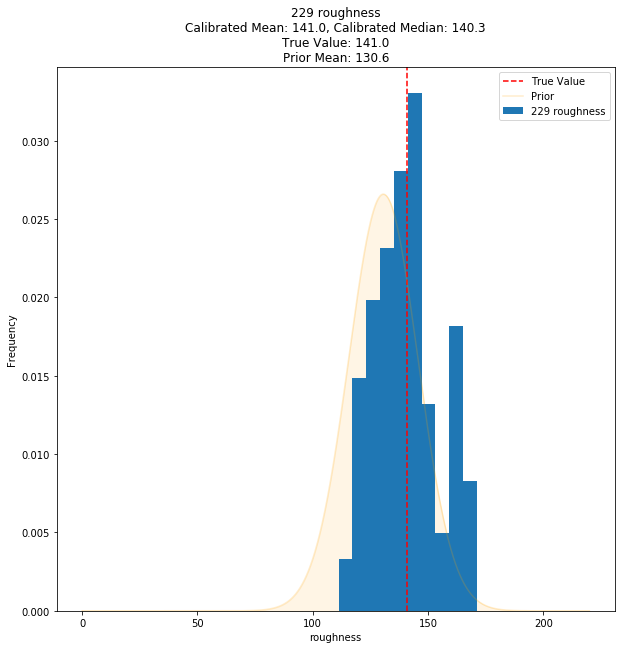

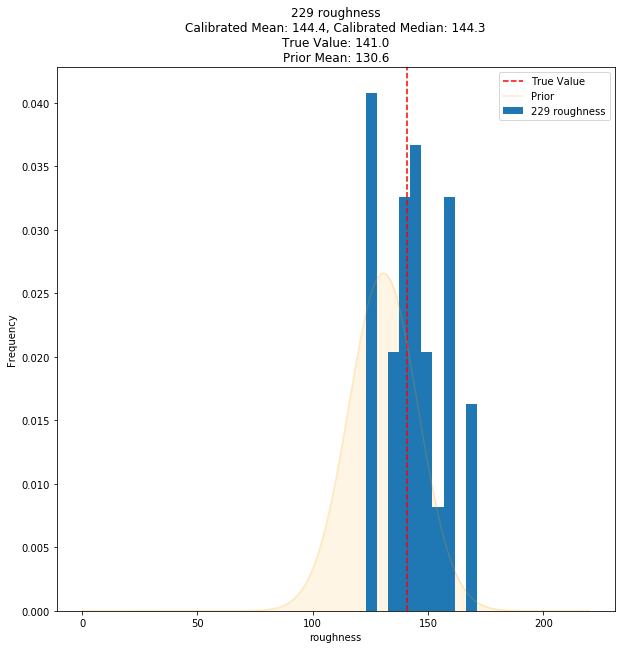

In [377]:
for i in range(0,len(listOfCalibrators)):
    listOfCalibrators[i].plot(trueValues[listOfCalibrators[i]],burnin=0.0)
    listOfCalibrators[i].plot(trueValues[listOfCalibrators[i]],burnin=0.5)

In [301]:
df_sensors.columns

Index(['109', '115', '116', '155', '163', '171', '177', '181', '189', '191',
       '205', '209', '215', '219', '235', '238', '247', '271', '277', '283',
       '287', '291', '295', '313'],
      dtype='object')

In [302]:
df_true.T.index

Index(['109', '115', '116', '155', '163', '171', '177', '181', '189', '191',
       '205', '209', '215', '219', '235', '238', '247', '271', '277', '283',
       '287', '291', '295', '313'],
      dtype='object')

Text(0.5, 1.0, 'Sensor and Calibrator Arrangement\nThick Lines are Calibrators\nThinner Lines are Sensors\nGrey Lines are Fixed')

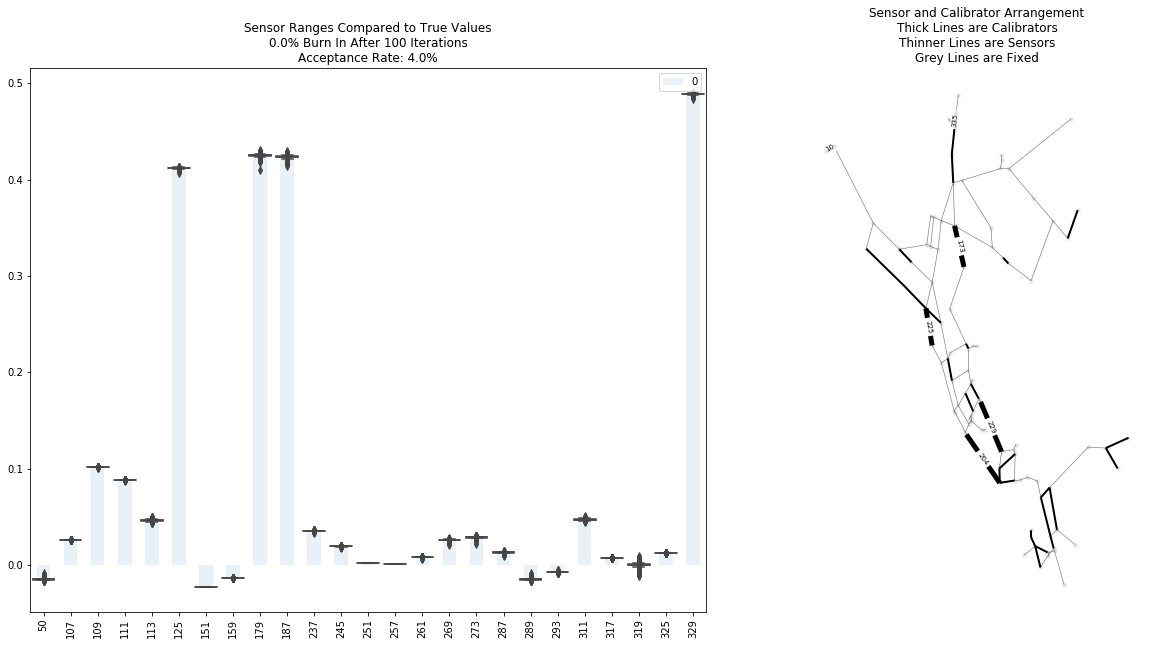

In [303]:
fig,(ax,mapAx) = plt.subplots(1,2,figsize=(20,10),gridspec_kw={'width_ratios':[2,1]})
dict_sensors = {}
dict_trueValues = {}
burnIn = 0.0
for sensor in listOfSensors:
    dict_sensors[sensor.name]=sensor.dictOfPropertyModelEstimates[5.00][int(burnIn*len(sensor.dictOfPropertyModelEstimates[5.00])):len(sensor.dictOfPropertyModelEstimates[5.00])+1]
    dict_trueValues[sensor.name] = [sensor.dictOfPropertyValues[5.00]]
df_sensors = pd.DataFrame(dict_sensors)
sns.boxplot(data=df_sensors,ax=ax)
# df_sensors.plot(kind="box",ax=ax)
df_true = pd.DataFrame(dict_trueValues)
df_true.T.plot(ax=ax,kind="bar",alpha=0.1)
ax.set_title(f"Sensor Ranges Compared to True Values\n{burnIn*100:.1f}% Burn In After {n} Iterations\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)*100:.1f}%")


baseNetwork = wntr.network.WaterNetworkModel(inp_file)
calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
sensorPipes = [sensor.name for sensor in listOfSensors]

for control in list(calibratorNetwork.controls()):
    try:
        calibratorNetwork.remove_control(control[0])
        sensorNetwork.remove_control(control[0])
    except:
        print(f"error removing {control[0]}")
        pass
    
for pipe in allPipes:
    if pipe not in calibratorPipes:
        try:
            calibratorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from calibrators")
    if pipe not in sensorPipes:
        try:
            sensorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from sensors")

wntr.graphics.plot_network(baseNetwork,link_alpha=0.1,node_alpha=0.1,ax=mapAx,link_labels=False)
wntr.graphics.plot_network(calibratorNetwork,ax=mapAx,node_alpha=0.0,link_labels=True,link_width=5,link_cmap=cm.autumn)
wntr.graphics.plot_network(sensorNetwork,ax=mapAx,node_alpha=0.0,link_labels=False,link_width=2)
mapAx.set_title("Sensor and Calibrator Arrangement\nThick Lines are Calibrators\nThinner Lines are Sensors\nGrey Lines are Fixed")

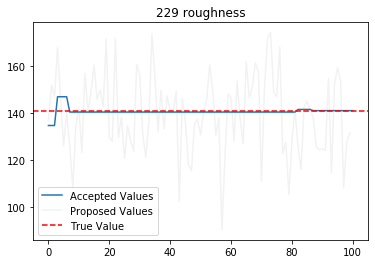

In [304]:
fig,ax = plt.subplots()
pd.DataFrame({"Accepted Values":calibrator.values}).plot(kind="line",ax=ax,label="Accepted Values")
pd.DataFrame({"Proposed Values":calibrator.proposedValues}).plot(kind="line",ax=ax,color="grey",alpha=0.1,label="Proposed Values")
ax.axhline(trueValues[calibrator],ls="--",color="red",label="True Value")
ax.legend()
ax.set_title(f"{calibrator.elementName} {calibrator.elementProperty}");

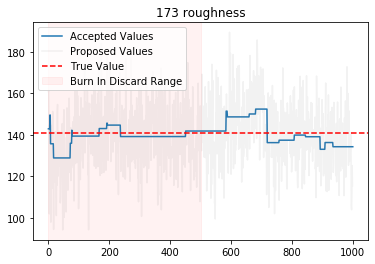

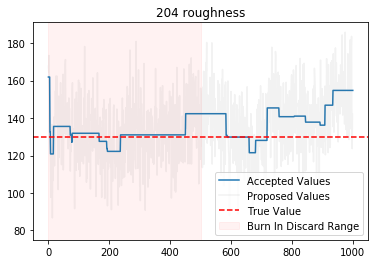

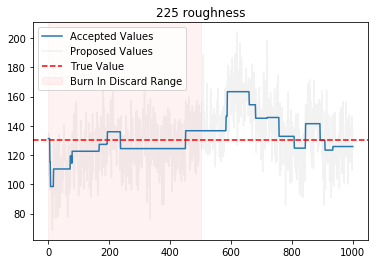

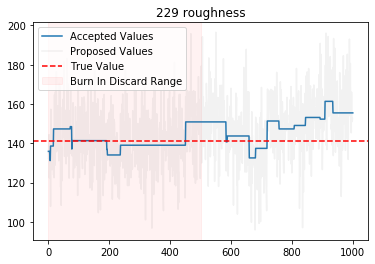

In [327]:
for calibrator in listOfCalibrators:
    burnin = 0.5
    fig,ax = plt.subplots()
    pd.DataFrame({"Accepted Values":calibrator.values}).plot(kind="line",ax=ax,label="Accepted Values")
    pd.DataFrame({"Proposed Values":calibrator.proposedValues}).plot(kind="line",ax=ax,color="grey",alpha=0.1,label="Proposed Values")
    ax.axhline(trueValues[calibrator],ls="--",color="red",label="True Value")
    ax.set_title(f"{calibrator.elementName} {calibrator.elementProperty}");
    ax.axvspan(0,int(burnin*len(calibrator.values)),alpha=0.05,color="red",label="Burn In Discard Range")
    ax.legend()

Text(0.5, 1.0, 'Sensor Locations')

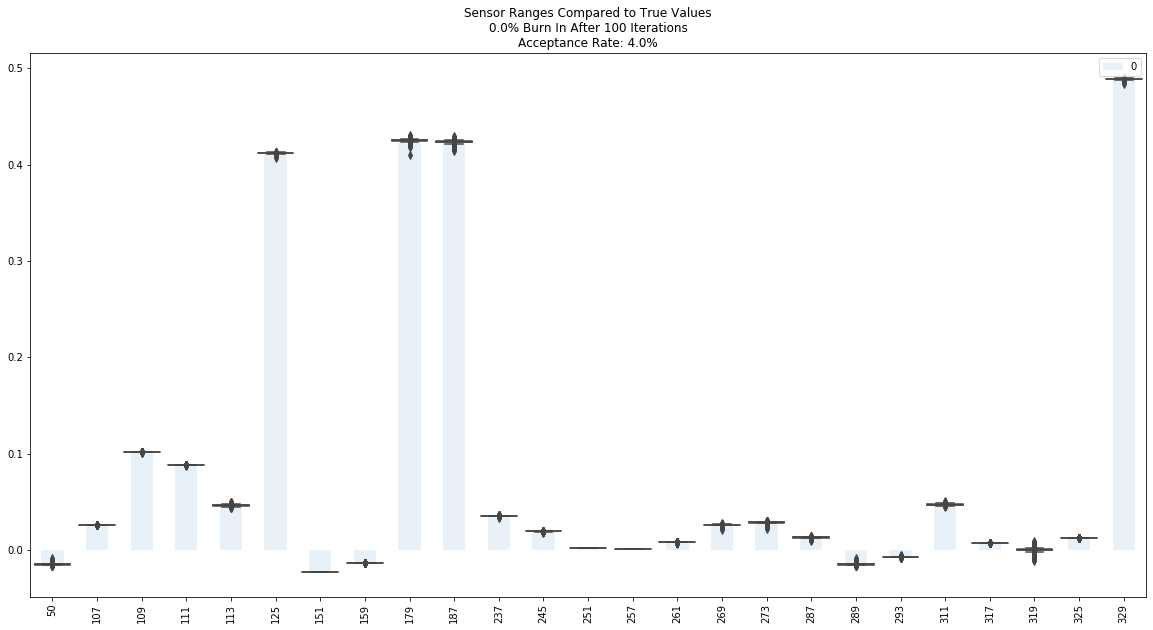

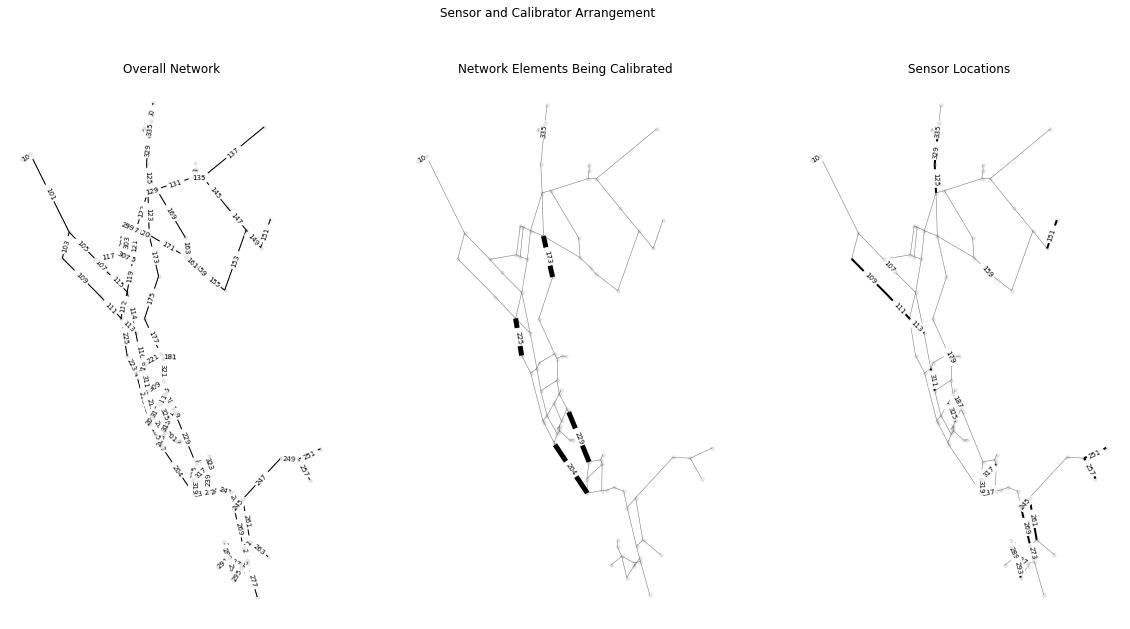

In [306]:
fig,ax = plt.subplots(figsize=(20,10))
dict_sensors = {}
dict_trueValues = {}
burnIn = 0.0
for sensor in listOfSensors:
    dict_sensors[sensor.name]=sensor.dictOfPropertyModelEstimates[5.00][int(burnIn*len(sensor.dictOfPropertyModelEstimates[5.00])):len(sensor.dictOfPropertyModelEstimates[5.00])+1]
    dict_trueValues[sensor.name] = [sensor.dictOfPropertyValues[5.00]]
df_sensors = pd.DataFrame(dict_sensors)
sns.boxplot(data=df_sensors,ax=ax)
# df_sensors.plot(kind="box",ax=ax)
df_true = pd.DataFrame(dict_trueValues)
df_true.T.plot(ax=ax,kind="bar",alpha=0.1)
ax.set_title(f"Sensor Ranges Compared to True Values\n{burnIn*100:.1f}% Burn In After {n} Iterations\nAcceptance Rate: {np.sum(isAccepted)/len(isAccepted)*100:.1f}%")


baseNetwork = wntr.network.WaterNetworkModel(inp_file)
calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
sensorPipes = [sensor.name for sensor in listOfSensors]

for control in list(calibratorNetwork.controls()):
    try:
        calibratorNetwork.remove_control(control[0])
        sensorNetwork.remove_control(control[0])
    except:
        print(f"error removing {control[0]}")
        pass
    
for pipe in allPipes:
    if pipe not in calibratorPipes:
        try:
            calibratorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from calibrators")
    if pipe not in sensorPipes:
        try:
            sensorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from sensors")

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))
wntr.graphics.plot_network(baseNetwork,link_alpha=1.0,node_alpha=0.1,ax=ax1,link_labels=True)
wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax2,link_labels=False)
wntr.graphics.plot_network(baseNetwork,link_alpha=0.05,node_alpha=0.1,ax=ax3,link_labels=False)
wntr.graphics.plot_network(calibratorNetwork,ax=ax2,node_alpha=0.0,link_labels=True,link_width=5,link_cmap=cm.autumn)
wntr.graphics.plot_network(sensorNetwork,ax=ax3,node_alpha=0.0,link_labels=True,link_width=2)
fig.suptitle("Sensor and Calibrator Arrangement")
ax1.set_title("Overall Network")
ax2.set_title("Network Elements Being Calibrated")
ax3.set_title("Sensor Locations")

(<matplotlib.collections.PathCollection at 0x1f50d111548>,
 <matplotlib.collections.LineCollection at 0x1f50871bd88>)

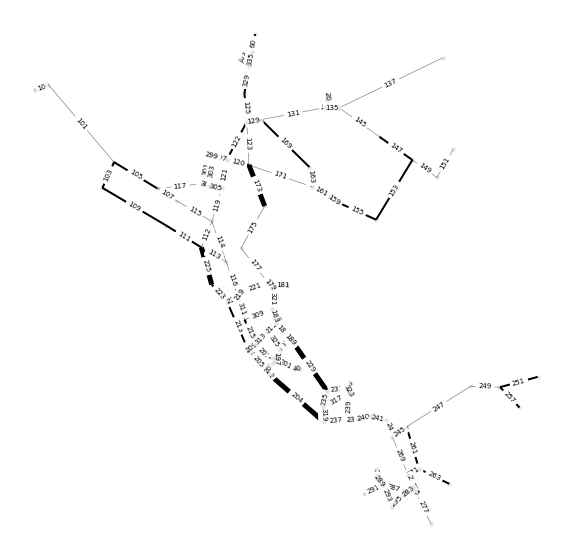

In [146]:
baseNetwork = wntr.network.WaterNetworkModel(inp_file)
calibratorNetwork = wntr.network.WaterNetworkModel(inp_file)
sensorNetwork = wntr.network.WaterNetworkModel(inp_file)

allPipes = [pipe[0] for pipe in baseNetwork.pipes()]

calibratorPipes = [calibrator.elementName for calibrator in listOfCalibrators]
sensorPipes = [sensor.name for sensor in listOfSensors]

for control in list(calibratorNetwork.controls()):
    try:
        calibratorNetwork.remove_control(control[0])
        sensorNetwork.remove_control(control[0])
    except:
        print(f"error removing {control[0]}")
        pass
    
for pipe in allPipes:
    if pipe not in calibratorPipes:
        try:
            calibratorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from calibrators")
    if pipe not in sensorPipes:
        try:
            sensorNetwork.remove_link(pipe)
        except:
            print(f"could not remove {pipe} from sensors")
            
fig,ax = plt.subplots(figsize=(10,10))
wntr.graphics.plot_network(baseNetwork,link_alpha=0.1,node_alpha=0.1,ax=ax,link_labels=True)
wntr.graphics.plot_network(calibratorNetwork,ax=ax,node_alpha=0.0,link_labels=True,link_width=5)
wntr.graphics.plot_network(sensorNetwork,ax=ax,node_alpha=0.0,link_labels=True,link_width=2)

# Let's do this

For simplicity, we are treating the only system states as flow rate, and the only parameters as pipe roughness

## Inputs

In [ ]:
class Parameter():
    def __init__(self,pipeName,value,distribution=None,isFixed=True):
        self.pipeName = pipeName
        self.value = value
        self.distribution = distribution
        self.isFixed = isFixed
        
    def generateValue(self):
        return 0
    
    def probabilityOfValue(self):
        return 0

In [ ]:
class Model():
    def __init__(self,wn,listOfParameters):
        self.wn = wn
        self.listOfParameters = listOfParameters

### Fixed Inputs

### Distributions of Priors

### Trusted System States and their Distributions (Uncertainty) for Calibration

## Methods

### $\pi$- Generates the random values for the parameters being tested

In [ ]:
def π():
    return 0

### $\pi_{prior}$- Calculates the probability that a set of parameter 'states' are pulled from their distributions

In [ ]:
def π_prior():
    return 0

### $\pi_{log liklihood}$- The sum of the log liklihood of each resulting system state matching the trusted system state

In [ ]:
def π_logLikelihood():
    return 0

### MCMC

In [ ]:
def MCMC():
    return 0

1. Set the parameters for the model, both fixed and pulling from distributions
2. Run the model with the selected parameters
3. Compare model results to the "sensor" feeds
4. Calculate the acceptance ratio

# Try professional library

In [316]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\theano\configdefaults.py:560: UserWarning:




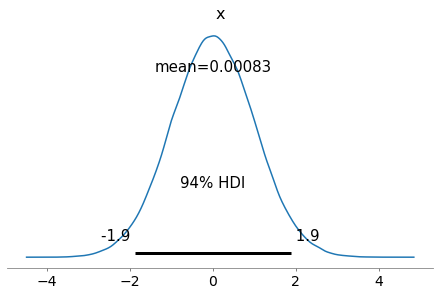

In [317]:
az.plot_posterior(np.random.randn(100000))

In [318]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

In [319]:
with pm.Model() as centered_eight:
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sd=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sd=sigma, observed=y)

    # This pattern is useful in PyMC3
    prior = pm.sample_prior_predictive()
    centered_eight_trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3423.58it/s]


In [320]:
az.plot_autocorr(centered_eight_trace, var_names=["mu", "tau"]);

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



AttributeError: Installed version of ArviZ requires PyMC3>=3.8. Please upgrade with `pip install pymc3>=3.8` or `conda install -c conda-forge pymc3>=3.8`.

In [321]:
from scipy.integrate import odeint

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])

# simulator function
def competition_model(a, b):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

In [322]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(a, b) + noise
    return simulated

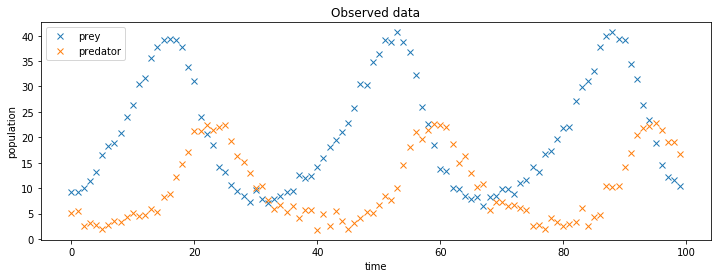

In [323]:

# plotting observed data.
observed = add_noise(a, b, c, d)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="prey")
ax.plot(observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();



In [325]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.)
    b = pm.HalfNormal("b", 1.)

    sim = pm.Simulator("sim", competition_model, params=(a, b),
                       epsilon=10,
                       observed=observed)

    trace_lv = pm.sample_smc(kernel="ABC", parallel=True)
    idata_lv = az.from_pymc3(trace_lv)



AttributeError: module 'pymc3' has no attribute 'Simulator'